<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Depth_Anything_Foundation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Depth Anything
Paper: https://arxiv.org/pdf/2401.10891.pdf

In [ ]:
!pip -q install git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#Please restart the session

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

raw input (480, 640)
raw input (480, 640) inputs torch.Size([1, 3, 518, 686]) predicted_depth torch.Size([1, 518, 686])
Original model train on the scale of 0 to 30
prediction: min scale = 4.3095164 max scale= 16.704033


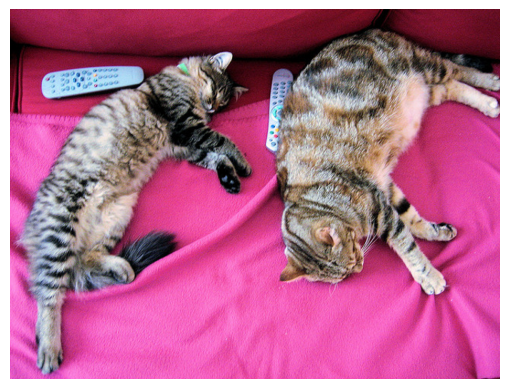

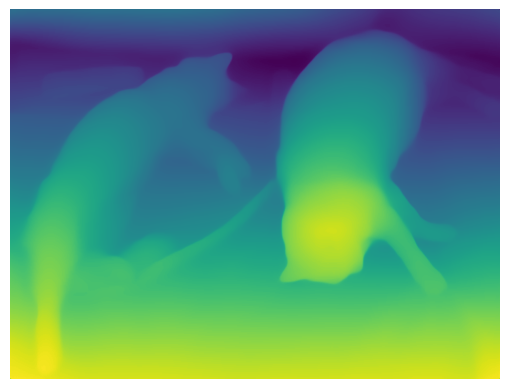

In [1]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# url = "https://machinelearningmastery.com/wp-content/uploads/2019/05/How-to-Develop-a-Convolutional-Neural-Network-to-Classify-Photos-of-Dogs-and-Cats-with-97-accuracy.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
# model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

print('raw input', image.size[::-1])
# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
prediction = predicted_depth.clone()
# interpolate to original size
# prediction = torch.nn.functional.interpolate(
#     predicted_depth.unsqueeze(1),
#     size=image.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# )

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/np.array(image_processor.image_std)),
                                transforms.Normalize(mean = np.array(image_processor.image_mean)*-1,
                                                     std = [ 1., 1., 1. ]),
                               ])
inv_tensor = invTrans(inputs['pixel_values'])
plt.figure(121),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.figure(122),plt.axis('OFF'),plt.imshow(depth);

In [2]:
model.config.backbone_config

Dinov2Config {
  "apply_layernorm": true,
  "architectures": [
    "Dinov2Model"
  ],
  "attention_probs_dropout_prob": 0.0,
  "drop_path_rate": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 518,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-06,
  "layerscale_value": 1.0,
  "mlp_ratio": 4,
  "model_type": "dinov2",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "out_features": [
    "stage9",
    "stage10",
    "stage11",
    "stage12"
  ],
  "out_indices": [
    9,
    10,
    11,
    12
  ],
  "patch_size": 14,
  "qkv_bias": true,
  "reshape_hidden_states": false,
  "stage_names": [
    "stem",
    "stage1",
    "stage2",
    "stage3",
    "stage4",
    "stage5",
    "stage6",
    "stage7",
    "stage8",
    "stage9",
    "stage10",
    "stage11",
    "stage12"
  ],
  "torch_dtype": "float32",
  "transformers_version": "4.41.2",
  "use_swiglu_ffn": false
}

raw input (480, 640)
h,w, p 256 320 14
hidden_states1 4 torch.Size([1, 397, 384]) torch.Size([1, 397, 384]) torch.Size([1, 397, 384]) torch.Size([1, 397, 384])
hidden_states2 4 torch.Size([1, 64, 18, 22]) torch.Size([1, 64, 36, 44]) torch.Size([1, 64, 72, 88]) torch.Size([1, 64, 144, 176])
raw input (480, 640) inputs torch.Size([1, 3, 256, 320]) predicted_depth torch.Size([1, 252, 308])
Original model train on the scale of 0 to 30
prediction: min scale = 4.475613 max scale= 12.24846


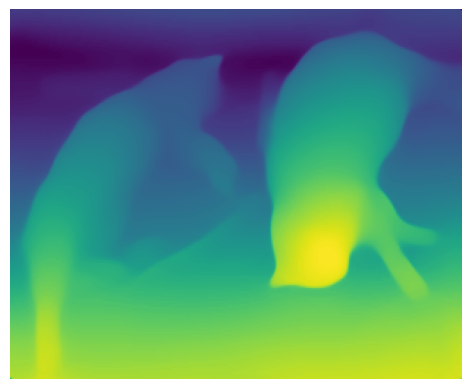

In [3]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

class DARES(nn.Module):
    def __init__(self,):
        super(DARES, self).__init__()
        model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
        self.config = model.config
        self.backbone = model.backbone
        self.neck = model.neck
        self.head = model.head
        model.post_init()


    def forward(self, pixel_values):
        outputs = self.backbone.forward_with_filtered_kwargs(
            pixel_values, output_hidden_states=None, output_attentions=None
        ) # pixel_values:[3, 256, 320] , output:4, [1, 397, 384]
        hidden_states = outputs.feature_maps
        _, _, height, width = pixel_values.shape
        patch_size = self.config.patch_size
        patch_height = height // patch_size
        patch_width = width // patch_size
        print('h,w, p', height, width, patch_size)
        print('hidden_states1', len(hidden_states), hidden_states[0].shape, hidden_states[1].shape, hidden_states[2].shape, hidden_states[3].shape)
        hidden_states = self.neck(hidden_states, patch_height, patch_width)
        #[1, 64, 18, 22], [1, 64, 36, 44], [1, 64, 72, 88], [1, 64, 144, 176]
        print('hidden_states2', len(hidden_states), hidden_states[0].shape, hidden_states[1].shape, hidden_states[2].shape, hidden_states[3].shape)
        predicted_depth = self.head(hidden_states, patch_height, patch_width)

        return predicted_depth
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
print('raw input', image.size[::-1])
inputs = image_processor(images=image, return_tensors="pt")
image_shape=(256,320)
inputs['pixel_values'] = torch.nn.functional.interpolate(inputs['pixel_values'], size=image_shape, mode="bilinear", align_corners=True)

model_dare = DARES()
inputs['pixel_values'] = inputs['pixel_values']
with torch.no_grad():
    predicted_depth = model_dare(**inputs)

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
# visualize the prediction
output = predicted_depth.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
plt.figure(122),plt.axis('OFF'),plt.imshow(depth);


In [ ]:
480/518, 427/350

(0.9266409266409267, 1.22)

In [ ]:
raw input (480, 640) inputs torch.Size([1, 3, 518, 686]) predicted_depth torch.Size([1, 518, 686])
raw input (427, 640) inputs torch.Size([1, 3, 350, 518]) predicted_depth torch.Size([1, 350, 518])



get_intermediate_layers0: 4 2 torch.Size([1, 320, 768]) torch.Size([1, 768])
get_intermediate_layers1: torch.Size([1, 320, 768]) torch.Size([1, 768])
get_intermediate_layers2: torch.Size([1, 320, 768]) torch.Size([1, 768])
get_intermediate_layers3: torch.Size([1, 320, 768]) torch.Size([1, 768])

In [ ]:
image_processor.image_mean, image_processor.image_std

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
inputs['pixel_values'].squeeze().permute(1,2,0).shape

torch.Size([350, 518, 3])

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

predicted_depth.shape

torch.Size([1, 518, 686])

In [ ]:
input = image_processor(images=image, return_tensors="pt")
input_res = input.copy()
pixel_values = input['pixel_values']
print(pixel_values.shape)
image_shape=(224,280)
input_res['pixel_values'] = torch.nn.functional.interpolate(pixel_values, size=image_shape, mode="bilinear", align_corners=True)
with torch.no_grad():
    outputs = model(**input_res)
    predicted_depth = outputs.predicted_depth

print('predicted_depth:', predicted_depth.shape)
# print(pixel_values.shape)
# h, w = pixel_values.shape[-2:]
# features = model.get_intermediate_layers(pixel_values, 4, return_class_token=True)

torch.Size([1, 3, 518, 686])
predicted_depth: torch.Size([1, 224, 280])


In [ ]:
import os
import torch
import torch.nn as nn

class DARES(nn.Module):
    def __init__(self,):
        super(DARES, self).__init__()
        model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

    def forward(self, pixel_values):
        return 0


In [ ]:
from transformers import DepthAnythingConfig, DepthAnythingForDepthEstimation

# Initializing a DepthAnything small style configuration
configuration = DepthAnythingConfig()

# Initializing a model from the DepthAnything small style configuration
model = DepthAnythingForDepthEstimation(configuration)
# model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# Accessing the model configuration
configuration = model.config

In [ ]:
model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

Liver: SCARED

In [ ]:
import gdown

d3k4_url = 'https://drive.google.com/uc?id=1_HrQTeZgU3AE88p1Ykawi2lkdijRNQVz'
gdown.download(d3k4_url,'d3k4.zip',quiet=True)
!unzip -q d3k4.zip
!mkdir liver
!mv -f d3k4 liver/

others

In [ ]:
import cv2
vidcap = cv2.VideoCapture('video.L.avi')
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read() #1920x1080
    try:
        image = cv2.resize(image, (1920, 1080))
    except:
        print('type:', type(image))

    if hasFrames:
        cv2.imwrite("liver2/image"+str(count)+".png", image)     # save frame as JPG file
    return hasFrames
sec = 0
frameRate = 0.5 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

type: <class 'NoneType'>


In [ ]:
image = Image.open('/content/liver2/image10.png')


# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

plt.figure(121),plt.axis('OFF'),plt.imshow(image)
plt.figure(122),plt.axis('OFF'),plt.imshow(depth);